### Configurations:

In [1]:
steps_per_epoch_init=1000 #(Ger - sentivity from 1000 to 5000, increment by 500)
epochs_init=25 #(Marvin - sentivity from 25 to 100, increment by 5)
validation_steps_init=100 #(Franco - sentivity from 100 to 500, increment by 50)

model_checkpoint_file = "GDN1000_LSTM_S1000_E25_V100.hdf5" #rename this with your name as prefix

#to all: please save 1 notebook per run

In [2]:
import os
fname = 'Hourly Demand_201301-201906_PH.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['DATE', 'YEAR', 'MONTH', 'WEEKDAY', ' HR ', 'PH']
56929


In [3]:
selected_columns = ['MONTH', 'WEEKDAY', ' HR ', 'PH']

In [4]:
import pandas as pd

data2 = pd.read_csv('Hourly Demand_201301-201906_PH.csv',usecols=selected_columns)

In [5]:
selected_columns = ['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH']

In [6]:
data2['DUMMY_TO_DELETE']=15

In [7]:
data2.head()

,MONTH,WEEKDAY,HR,PH,DUMMY_TO_DELETE
0,1,2,1,6331,15
1,1,2,2,5702,15
2,1,2,3,5373,15
3,1,2,4,5121,15
4,1,2,5,5029,15


In [8]:
data2=data2[selected_columns]

In [9]:
data2.head()

,DUMMY_TO_DELETE,MONTH,WEEKDAY,HR,PH
0,15,1,2,1,6331
1,15,1,2,2,5702
2,15,1,2,3,5373
3,15,1,2,4,5121
4,15,1,2,5,5029


In [10]:
dummy=data2
dummy.head()

,DUMMY_TO_DELETE,MONTH,WEEKDAY,HR,PH
0,15,1,2,1,6331
1,15,1,2,2,5702
2,15,1,2,3,5373
3,15,1,2,4,5121
4,15,1,2,5,5029


In [11]:
data2.to_csv("Hourly Demand_201301-201906_ALL_PH_MOD.csv",index=False)

In [12]:
import os
fname = 'Hourly Demand_201301-201906_ALL_PH_MOD.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:len(lines)-1]
print(header)
print(len(lines))
#print(lines)

['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH']
56928


In [13]:
import pandas as pd

data2 = pd.read_csv('Hourly Demand_201301-201906_ALL_PH_MOD.csv',usecols=selected_columns)
dummy=data2
dummy.head()

,DUMMY_TO_DELETE,MONTH,WEEKDAY,HR,PH
0,15,1,2,1,6331
1,15,1,2,2,5702
2,15,1,2,3,5373
3,15,1,2,4,5121
4,15,1,2,5,5029


In [14]:
len(lines), len(header)

(56928, 5)

In [15]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [16]:
dummy.describe()

,DUMMY_TO_DELETE,MONTH,WEEKDAY,HR,PH
count,56928.0,56928.000000,56928.000000,56928.000000,56928.000000
mean,15.0,6.293845,4.001265,12.500000,9476.398029
std,0.0,3.442168,1.999490,6.922247,1855.469031
min,15.0,1.000000,1.000000,1.000000,3209.000000
25%,15.0,3.000000,2.000000,6.750000,8096.000000
50%,15.0,6.000000,4.000000,12.500000,9401.000000
75%,15.0,9.000000,6.000000,18.250000,10773.000000
max,15.0,12.000000,7.000000,24.000000,15369.000000


In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

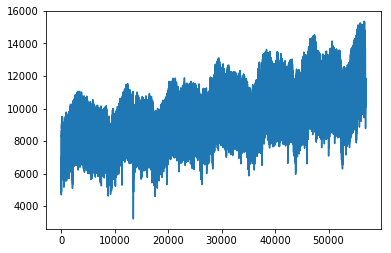

In [18]:
temp = dummy["PH"]
plt.plot(range(len(temp)), temp)

In [19]:
NN_data=float_data

In [20]:
train_count = int(len(NN_data)*.7)
validate_count = int((len(NN_data)-train_count)*0.5)
test_count = len(NN_data)-train_count-validate_count

train_count,validate_count,test_count

(39849, 8539, 8540)

In [21]:
mean = NN_data[:train_count].mean(axis=0)
NN_data -= mean
std = NN_data[:train_count].std(axis=0)
NN_data /= std

In [22]:
NN_data

array([[-1.52188013, -0.9993697 , -1.6610214 , -1.59968355],
       [-1.52188013, -0.9993697 , -1.51656348, -1.98956918],
       [-1.52188013, -0.9993697 , -1.37210556, -2.19349982],
       ...,
       [-0.0584152 ,  1.5008427 ,  1.37259495,  1.4896487 ],
       [-0.0584152 ,  1.5008427 ,  1.51705287,  1.08860577],
       [-0.0584152 ,  1.5008427 ,  1.66151079,  0.73715083]])

In [23]:
mean, std

(array([6.19957841e+00, 3.99856960e+00, 1.24983061e+01, 8.91175927e+03]),
 array([   3.41654924,    1.99983009,    6.92243105, 1613.29361826]))

## Define Target Column

In [24]:
dummy.columns

Index(['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH'], dtype='object')

In [25]:
len(dummy.columns)

5

In [26]:
target_column = len(dummy.columns)-2

In [27]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_column]
        yield samples, targets

In [28]:
float_data.shape

(56928, 4)

In [29]:
float_data[train_count+validate_count+1],float_data[train_count+validate_count+1][target_column]

(array([ 0.23427779, -0.9993697 , -0.93873179,  0.19168286]),
 0.19168285938147817)

In [30]:
len(NN_data)

56928

In [31]:
train_count,validate_count,test_count

(39849, 8539, 8540)

### SET TIME SERIES DATA - 3 hours historical

In [32]:
lookback = 3 # no. of hours to use to forecast next hour
step = 1 # 1 for hourly, 24 for daily, etc.
delay = 1 # no. of hour(s) to forecast
batch_size = 64 # no of records per epoch, each record contains "lookback" hours of input and "delay" hours of output, 
### 2 ^ n batch_size. i.e.2,4,8,16

### GENERATE (TRANSFORM/PIVOT) DATA

In [33]:
train_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_count,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+1,
    max_index=train_count+validate_count,
    step=step,
    batch_size=batch_size)

test_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+validate_count+1,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (validate_count - 1 - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = (test_count - 1 - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

In [34]:
val_steps,test_steps

(8535, 8536)

In [35]:
train_gen, val_gen, test_gen

(<generator object generator at 0x7f47437e1048>,
 <generator object generator at 0x7f47437e10c0>,
 <generator object generator at 0x7f47437e1138>)

In [36]:
target_column

3

In [37]:
import numpy as np

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, target_column]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

naive_mae = evaluate_naive_method()


0.4248809354877904


In [38]:
dummy.columns

Index(['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH'], dtype='object')

In [39]:
naive_mae*std

array([  1.45162664,   0.84968968,   2.94120898, 685.45770174])

In [40]:
float_data = NN_data

In [41]:
float_data[1]

array([-1.52188013, -0.9993697 , -1.51656348, -1.98956918])

In [42]:
std

array([   3.41654924,    1.99983009,    6.92243105, 1613.29361826])

In [43]:
mean

array([6.19957841e+00, 3.99856960e+00, 1.24983061e+01, 8.91175927e+03])

### LSTM

In [44]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

Using TensorFlow backend.


In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [46]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(model_checkpoint_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [47]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=steps_per_epoch_init,
                                epochs=epochs_init,
                                validation_data=val_gen,
                                validation_steps=validation_steps_init,
                              callbacks=[checkpoint])

Epoch 1/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2819 - val_loss: 0.2269
Epoch 2/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2166 - val_loss: 0.2900
Epoch 3/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1935 - val_loss: 0.1398
Epoch 4/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1640 - val_loss: 0.1380
Epoch 5/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1439 - val_loss: 0.1409
Epoch 6/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1238 - val_loss: 0.1352
Epoch 7/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1040 - val_loss: 0.0866
Epoch 8/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0914 - val_loss: 0.0859
Epoch 9/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0852 - val_loss: 0.1044
Epoch 10/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.080

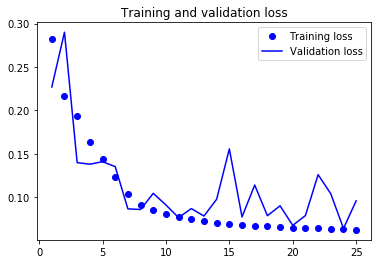

In [48]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### SET TIME SERIES DATA - 3 days historical

In [49]:
lookback = 3*24 # no. of hours to use to forecast next hour
step = 1 # 1 for hourly, 24 for daily, etc.
delay = 1 # no. of hour(s) to forecast
batch_size = 64 # no of records per epoch, each record contains "lookback" hours of input and "delay" hours of output, 
### 2 ^ n batch_size. i.e.2,4,8,16

### GENERATE (TRANSFORM/PIVOT) DATA

In [50]:
train_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_count,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+1,
    max_index=train_count+validate_count,
    step=step,
    batch_size=batch_size)

test_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+validate_count+1,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (validate_count - 1 - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = (test_count - 1 - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

In [51]:
val_steps,test_steps

(8466, 8467)

In [52]:
train_gen, val_gen, test_gen

(<generator object generator at 0x7f47285909a8>,
 <generator object generator at 0x7f4728590930>,
 <generator object generator at 0x7f4728590a20>)

In [53]:
import numpy as np

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, target_column]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

naive_mae = evaluate_naive_method()


0.4252675914919546


In [54]:
dummy.columns

Index(['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH'], dtype='object')

In [55]:
naive_mae*std

array([  1.45294766,   0.85046293,   2.94388558, 686.08149141])

In [56]:
float_data = NN_data

In [57]:
float_data[1]

array([-1.52188013, -0.9993697 , -1.51656348, -1.98956918])

### LSTM

In [58]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [60]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(model_checkpoint_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [61]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=steps_per_epoch_init,
                                epochs=epochs_init,
                                validation_data=val_gen,
                                validation_steps=validation_steps_init,
                              callbacks=[checkpoint])

Epoch 1/25
1000/1000 [==============================] - 80s 80ms/step - loss: 0.1849 - val_loss: 0.2009
Epoch 2/25
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1037 - val_loss: 0.1106
Epoch 3/25
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0831 - val_loss: 0.1069
Epoch 4/25
1000/1000 [==============================] - 77s 77ms/step - loss: 0.0734 - val_loss: 0.0569
Epoch 5/25
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0685 - val_loss: 0.1424
Epoch 6/25
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0660 - val_loss: 0.0721
Epoch 7/25
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0633 - val_loss: 0.0639
Epoch 8/25
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0618 - val_loss: 0.0534
Epoch 9/25
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0605 - val_loss: 0.1145
Epoch 10/25
1000/1000 [==============================] - 75s 75m

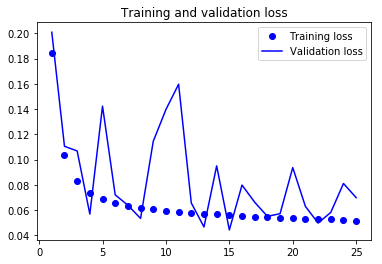

In [62]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### SET TIME SERIES DATA - 3 weeks historical

In [63]:
lookback = 3*24*7 # no. of hours to use to forecast next hour
step = 1 # 1 for hourly, 24 for daily, etc.
delay = 1 # no. of hour(s) to forecast
batch_size = 64 # no of records per epoch, each record contains "lookback" hours of input and "delay" hours of output, 
### 2 ^ n batch_size. i.e.2,4,8,16

### GENERATE (TRANSFORM/PIVOT) DATA

In [64]:
train_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_count,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+1,
    max_index=train_count+validate_count,
    step=step,
    batch_size=batch_size)

test_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+validate_count+1,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (validate_count - 1 - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = (test_count - 1 - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

In [65]:
val_steps,test_steps

(8034, 8035)

In [66]:
train_gen, val_gen, test_gen

(<generator object generator at 0x7f46f01a5480>,
 <generator object generator at 0x7f46f01a5408>,
 <generator object generator at 0x7f46f01a54f8>)

In [67]:
import numpy as np

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, target_column]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

naive_mae = evaluate_naive_method()


0.42532970243500245


In [68]:
dummy.columns

Index(['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH'], dtype='object')

In [69]:
naive_mae*std

array([  1.45315987,   0.85058714,   2.94431554, 686.18169459])

In [70]:
float_data = NN_data

In [71]:
float_data[1]

array([-1.52188013, -0.9993697 , -1.51656348, -1.98956918])

### LSTM

In [72]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [74]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(model_checkpoint_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [75]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=steps_per_epoch_init,
                                epochs=epochs_init,
                                validation_data=val_gen,
                                validation_steps=validation_steps_init,
                              callbacks=[checkpoint])

Epoch 1/25
1000/1000 [==============================] - 475s 475ms/step - loss: 0.1845 - val_loss: 0.1517
Epoch 2/25
1000/1000 [==============================] - 472s 472ms/step - loss: 0.1093 - val_loss: 0.1299
Epoch 3/25
1000/1000 [==============================] - 472s 472ms/step - loss: 0.0835 - val_loss: 0.1176
Epoch 4/25
1000/1000 [==============================] - 468s 468ms/step - loss: 0.0740 - val_loss: 0.0751
Epoch 5/25
1000/1000 [==============================] - 464s 464ms/step - loss: 0.0682 - val_loss: 0.0663
Epoch 6/25
1000/1000 [==============================] - 470s 470ms/step - loss: 0.0651 - val_loss: 0.0865
Epoch 7/25
1000/1000 [==============================] - 471s 471ms/step - loss: 0.0626 - val_loss: 0.0849
Epoch 8/25
1000/1000 [==============================] - 458s 458ms/step - loss: 0.0614 - val_loss: 0.0583
Epoch 9/25
1000/1000 [==============================] - 459s 459ms/step - loss: 0.0599 - val_loss: 0.0638
Epoch 10/25
1000/1000 [=======================

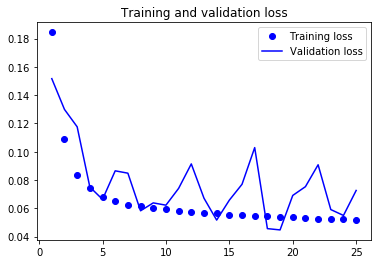

In [76]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### SET TIME SERIES DATA - 3 months historical

In [77]:
lookback = 3*24*7*4 # no. of hours to use to forecast next hour
step = 1 # 1 for hourly, 24 for daily, etc.
delay = 1 # no. of hour(s) to forecast
batch_size = 64 # no of records per epoch, each record contains "lookback" hours of input and "delay" hours of output, 
### 2 ^ n batch_size. i.e.2,4,8,16

### GENERATE (TRANSFORM/PIVOT) DATA

In [78]:
train_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_count,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+1,
    max_index=train_count+validate_count,
    step=step,
    batch_size=batch_size)

test_gen = generator(NN_data,
    lookback=lookback,
    delay=delay,
    min_index=train_count+validate_count+1,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (validate_count - 1 - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = (test_count - 1 - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

In [79]:
val_steps,test_steps

(6522, 6523)

In [80]:
train_gen, val_gen, test_gen

(<generator object generator at 0x7f46e80fa4f8>,
 <generator object generator at 0x7f46e80fa480>,
 <generator object generator at 0x7f46e80fa570>)

In [81]:
import numpy as np

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, target_column]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

naive_mae = evaluate_naive_method()


0.4262984915823665


In [82]:
dummy.columns

Index(['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH'], dtype='object')

In [83]:
naive_mae*std

array([  1.45646979,   0.85252455,   2.95102191, 687.74463594])

In [84]:
float_data = NN_data

In [85]:
float_data[1]

array([-1.52188013, -0.9993697 , -1.51656348, -1.98956918])

### LSTM

In [86]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [88]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(model_checkpoint_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [89]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=steps_per_epoch_init,
                                epochs=epochs_init,
                                validation_data=val_gen,
                                validation_steps=validation_steps_init,
                              callbacks=[checkpoint])

Epoch 1/25
1000/1000 [==============================] - 1969s 2s/step - loss: 0.1769 - val_loss: 0.1405
Epoch 2/25
1000/1000 [==============================] - 1963s 2s/step - loss: 0.0981 - val_loss: 0.1110
Epoch 3/25
1000/1000 [==============================] - 1956s 2s/step - loss: 0.0796 - val_loss: 0.1124
Epoch 4/25
1000/1000 [==============================] - 1951s 2s/step - loss: 0.0723 - val_loss: 0.0692
Epoch 5/25
1000/1000 [==============================] - 1951s 2s/step - loss: 0.0673 - val_loss: 0.0693
Epoch 6/25
1000/1000 [==============================] - 1950s 2s/step - loss: 0.0642 - val_loss: 0.0639
Epoch 7/25
1000/1000 [==============================] - 1903s 2s/step - loss: 0.0628 - val_loss: 0.0580
Epoch 8/25
1000/1000 [==============================] - 1871s 2s/step - loss: 0.0610 - val_loss: 0.0600
Epoch 9/25
1000/1000 [==============================] - 1869s 2s/step - loss: 0.0590 - val_loss: 0.0722
Epoch 10/25
1000/1000 [==============================] - 1868s 2

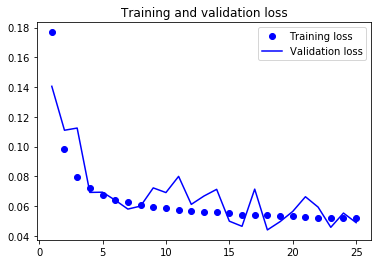

In [90]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## END MODEL